In [1]:
%pip install -q pandas numpy scikit-learn matplotlib seaborn catboost joblib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost import CatBoostRegressor
import joblib

pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42

In [7]:
CSV_PATH = "/Users/manansharma/Documents/New project/Dataset.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head()

Shape: (45593, 11)


ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  4607     INDORES13DEL02                   37                      4.9   
1  B379     BANGRES18DEL02                   34                      4.5   
2  5D6D     BANGRES19DEL01                   23                      4.4   
3  7A6A    COIMBRES13DEL02                   38                      4.7   
4  70A2     CHENRES12DEL01                   32                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude Type_of_order Type_of_vehicle  \
0                    75.912471        Snack      motorcycle    
1                    77.813237        Snack         scooter    
2                    77.688400       Drinks      motorcycle    
3                    77.026494       Buffet      motorcycle    
4                    80.289982        Snack         scooter    

   Delivery Time_taken(min)  
0                        24  
1                        33  
2                        26  
3                        21  
4                        30

In [9]:
print(df.info())
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Delivery Time_taken(min)     45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB
None

Missing values:
 ID                             0
Delivery_person_ID 

In [11]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(r"[^a-z0-9_]", "", regex=True)
)

for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

df.head()

id delivery_person_id  delivery_person_age  delivery_person_ratings  \
0  4607     INDORES13DEL02                   37                      4.9   
1  B379     BANGRES18DEL02                   34                      4.5   
2  5D6D     BANGRES19DEL01                   23                      4.4   
3  7A6A    COIMBRES13DEL02                   38                      4.7   
4  70A2     CHENRES12DEL01                   32                      4.6   

   restaurant_latitude  restaurant_longitude  delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   delivery_location_longitude type_of_order type_of_vehicle  \
0                    75.912471         Snack      motorcycle   
1                    77.813237         Snack         scooter   
2                    77.688400        Drinks      motorcycle   
3                    77.026494        Buffet      motorcycle   
4                    80.289982         Snack         scooter   

   delivery_time_takenmin  
0                      24  
1                      33  
2                      26  
3                      21  
4                      30

In [13]:
df = df.rename(columns={"delivery_time_takenmin": "delivery_time_min"})

numeric_cols = [
    "delivery_person_age",
    "delivery_person_ratings",
    "restaurant_latitude",
    "restaurant_longitude",
    "delivery_location_latitude",
    "delivery_location_longitude",
    "delivery_time_min",
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df[numeric_cols].isna().sum())

delivery_person_age            0
delivery_person_ratings        0
restaurant_latitude            0
restaurant_longitude           0
delivery_location_latitude     0
delivery_location_longitude    0
delivery_time_min              0
dtype: int64


In [15]:
df["delivery_person_age"] = df["delivery_person_age"].clip(lower=18, upper=60)
df["delivery_person_ratings"] = df["delivery_person_ratings"].clip(lower=1.0, upper=5.0)

df[["delivery_person_age", "delivery_person_ratings"]].describe()

delivery_person_age  delivery_person_ratings
count         45593.000000             45593.000000
mean             29.546575                 4.631204
std               5.691064                 0.324613
min              18.000000                 1.000000
25%              25.000000                 4.600000
50%              29.000000                 4.700000
75%              34.000000                 4.800000
max              50.000000                 5.000000

In [17]:
pattern = r"^([A-Z]+)RES(\d+)DEL(\d+)$"
extracted = df["delivery_person_id"].str.extract(pattern)
df["city"] = extracted[0].fillna("UNKNOWN")
df["restaurant_code"] = extracted[1].fillna("-1")
df["rider_code"] = extracted[2].fillna("-1")

df[["delivery_person_id", "city", "restaurant_code", "rider_code"]].head()

delivery_person_id   city restaurant_code rider_code
0     INDORES13DEL02   INDO              13         02
1     BANGRES18DEL02   BANG              18         02
2     BANGRES19DEL01   BANG              19         01
3    COIMBRES13DEL02  COIMB              13         02
4     CHENRES12DEL01   CHEN              12         01

In [21]:
coord_cols = [
    "restaurant_latitude",
    "restaurant_longitude",
    "delivery_location_latitude",
    "delivery_location_longitude",
]

# Mark coordinate validity in India-like bounds
def is_valid_coord_frame(x):
    return (
        x["restaurant_latitude"].between(6, 38)
        & x["restaurant_longitude"].between(68, 98)
        & x["delivery_location_latitude"].between(6, 38)
        & x["delivery_location_longitude"].between(68, 98)
    )

df["geo_valid"] = is_valid_coord_frame(df)
print("Invalid geo rows before fix:", (~df["geo_valid"]).sum())

# Set invalid geo rows to NaN for controlled imputation
df.loc[~df["geo_valid"], coord_cols] = np.nan

# City-wise median fill
for c in coord_cols:
    df[c] = df[c].fillna(df.groupby("city")[c].transform("median"))

# Global median fallback
for c in coord_cols:
    df[c] = df[c].fillna(df[c].median())

df["geo_valid_after_fix"] = is_valid_coord_frame(df)
print("Invalid geo rows after fix:", (~df["geo_valid_after_fix"]).sum())


Invalid geo rows before fix: 4071
Invalid geo rows after fix: 0


In [23]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["haversine_km"] = haversine_km(
    df["restaurant_latitude"],
    df["restaurant_longitude"],
    df["delivery_location_latitude"],
    df["delivery_location_longitude"],
)

df["lat_diff_abs"] = (df["delivery_location_latitude"] - df["restaurant_latitude"]).abs()
df["lon_diff_abs"] = (df["delivery_location_longitude"] - df["restaurant_longitude"]).abs()
df["manhattan_proxy_km"] = (df["lat_diff_abs"] + df["lon_diff_abs"]) * 111

df["distance_bucket"] = pd.cut(
    df["haversine_km"],
    bins=[-0.001, 2, 5, 10, 20, np.inf],
    labels=["very_short", "short", "medium", "long", "very_long"]
)

df[["haversine_km", "manhattan_proxy_km", "distance_bucket"]].describe(include="all")

haversine_km  manhattan_proxy_km distance_bucket
count   45593.000000        45593.000000           45593
unique           NaN                 NaN               5
top              NaN                 NaN            long
freq             NaN                 NaN           17704
mean        9.690756           14.100340             NaN
std         5.349584            7.792070             NaN
min         1.465067            2.219889             NaN
25%         5.958808            8.880000             NaN
50%         9.255030           13.320000             NaN
75%        13.406350           19.980000             NaN
max        20.969489           31.080000             NaN

In [25]:
# Drop rows with missing target only
df = df.dropna(subset=["delivery_time_min"]).copy()

# Keep ID out; keep engineered city-level features
drop_cols = ["id", "delivery_person_id", "delivery_time_min", "geo_valid_after_fix"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["delivery_time_min"]

print("Final training shape:", X.shape)
print("Target shape:", y.shape)
X.head()

Final training shape: (45593, 17)
Target shape: (45593,)


delivery_person_age  delivery_person_ratings  restaurant_latitude  \
0                   37                      4.9            22.745049   
1                   34                      4.5            12.913041   
2                   23                      4.4            12.914264   
3                   38                      4.7            11.003669   
4                   32                      4.6            12.972793   

   restaurant_longitude  delivery_location_latitude  \
0             75.892471                   22.765049   
1             77.683237                   13.043041   
2             77.678400                   12.924264   
3             76.976494                   11.053669   
4             80.249982                   13.012793   

   delivery_location_longitude type_of_order type_of_vehicle   city  \
0                    75.912471         Snack      motorcycle   INDO   
1                    77.813237         Snack         scooter   BANG   
2                    77.688400        Drinks      motorcycle   BANG   
3                    77.026494        Buffet      motorcycle  COIMB   
4                    80.289982         Snack         scooter   CHEN   

  restaurant_code rider_code  geo_valid  haversine_km  lat_diff_abs  \
0              13         02       True      3.025149          0.02   
1              18         02       True     20.183530          0.13   
2              19         01       True      1.552758          0.01   
3              13         02       True      7.790401          0.05   
4              12         01       True      6.210138          0.04   

   lon_diff_abs  manhattan_proxy_km distance_bucket  
0          0.02                4.44           short  
1          0.13               28.86       very_long  
2          0.01                2.22      very_short  
3          0.05               11.10          medium  
4          0.04                8.88          medium

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (36474, 17) Test: (9119, 17)


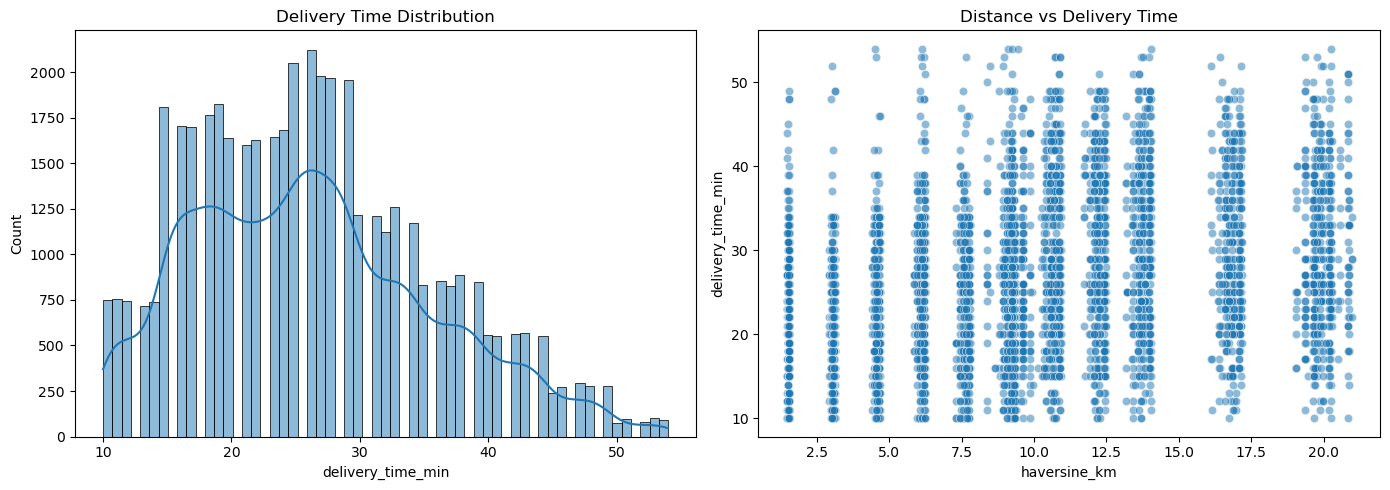

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df["delivery_time_min"], kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title("Delivery Time Distribution")

sns.scatterplot(
    data=df.sample(min(5000, len(df)), random_state=RANDOM_STATE),
    x="haversine_km",
    y="delivery_time_min",
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title("Distance vs Delivery Time")
plt.tight_layout()
plt.show()

In [31]:
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ]
)

lin_model = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

rf_model = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

lin_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['delivery_person_age',
                                                   'delivery_person_ratings',
                                                   'restaurant_latitude',
                                                   'restaurant_longitude',
                                                   'delivery_location_latitude',
                                                   'delivery_location_longitude',
                                                   'haversine_km',
                                                   'lat_diff_abs',
                                                   'lon_diff_abs...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type_of_order',
                                                   'type_of_vehicle', 'city',
                                                   'restaurant_code',
                                                   'rider_code', 'geo_valid',
                                                   'distance_bucket'])])),
                ('model',
                 RandomForestRegressor(min_samples_leaf=2, min_samples_split=4,
                                       n_estimators=300, n_jobs=-1,
                                       random_state=42))])

In [32]:
# CatBoost works directly with categorical columns
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

for c in cat_features:
    X_train_cb[c] = X_train_cb[c].astype(str)
    X_test_cb[c] = X_test_cb[c].astype(str)

cat_feature_indices = [X_train_cb.columns.get_loc(c) for c in cat_features]

cb_model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    learning_rate=0.05,
    depth=8,
    n_estimators=2000,
    l2_leaf_reg=5,
    subsample=0.8,
    random_seed=RANDOM_STATE,
    verbose=200
)

cb_model.fit(
    X_train_cb, y_train,
    cat_features=cat_feature_indices,
    eval_set=(X_test_cb, y_test),
    use_best_model=True,
    early_stopping_rounds=150
)

0:	learn: 9.2148714	test: 9.1927419	best: 9.1927419 (0)	total: 90.3ms	remaining: 3m
200:	learn: 7.2030896	test: 7.2689830	best: 7.2689830 (200)	total: 3.1s	remaining: 27.8s
400:	learn: 7.0925121	test: 7.2605394	best: 7.2602941 (397)	total: 6.01s	remaining: 24s
600:	learn: 7.0017705	test: 7.2617790	best: 7.2588449 (454)	total: 8.45s	remaining: 19.7s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 7.258844907
bestIteration = 454

Shrink model to first 455 iterations.


In [33]:
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

pred_lin = lin_model.predict(X_test)
pred_rf = rf_model.predict(X_test)
pred_cb = cb_model.predict(X_test_cb)

rows = []
for name, pred in [
    ("Linear Regression", pred_lin),
    ("Random Forest", pred_rf),
    ("CatBoost (Geo + Categorical)", pred_cb),
]:
    rmse, mae, r2 = regression_metrics(y_test, pred)
    rows.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})

results = pd.DataFrame(rows).sort_values("RMSE")
results

Model      RMSE       MAE        R2
2  CatBoost (Geo + Categorical)  7.258845  5.697445  0.399043
1                 Random Forest  7.589889  5.934927  0.342979
0             Linear Regression  7.831345  6.255971  0.300510

In [37]:
importances = cb_model.get_feature_importance()
feat_imp = pd.DataFrame({
    "feature": X_train_cb.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(15)

feature  importance
1       delivery_person_ratings   38.212221
0           delivery_person_age   22.445636
7               type_of_vehicle    9.311000
15           manhattan_proxy_km    7.101839
16              distance_bucket    3.884942
12                 haversine_km    3.466484
14                 lon_diff_abs    2.605289
13                 lat_diff_abs    2.251384
10                   rider_code    1.867360
8                          city    1.863823
9               restaurant_code    1.700433
6                 type_of_order    1.237252
11                    geo_valid    1.128091
3          restaurant_longitude    0.824637
5   delivery_location_longitude    0.735259

In [39]:
BEST_MODEL_PATH = "/Users/manansharma/Documents/New project/best_catboost_model.cbm"
META_PATH = "/Users/manansharma/Documents/New project/model_features.joblib"

cb_model.save_model(BEST_MODEL_PATH)
joblib.dump({
    "feature_columns": X_train_cb.columns.tolist(),
    "categorical_columns": cat_features,
}, META_PATH)

print("Saved:", BEST_MODEL_PATH)
print("Saved:", META_PATH)

Saved: /Users/manansharma/Documents/New project/best_catboost_model.cbm
Saved: /Users/manansharma/Documents/New project/model_features.joblib


In [41]:
def predict_eta(single_row_df: pd.DataFrame):
    # single_row_df must contain same feature columns as X_train_cb
    data = single_row_df.copy()
    for c in cat_features:
        if c in data.columns:
            data[c] = data[c].astype(str)
    return cb_model.predict(data)

# Example:
sample_pred = predict_eta(X_test_cb.iloc[[0]])
print("Predicted ETA (min):", float(sample_pred[0]))
print("Actual ETA (min):", float(y_test.iloc[0]))

Predicted ETA (min): 33.093585615211865
Actual ETA (min): 44.0


In [43]:
streamlit_code = """
import numpy as np
import pandas as pd
import joblib
from catboost import CatBoostRegressor
import streamlit as st

MODEL_PATH = "/Users/manansharma/Documents/New project/best_catboost_model.cbm"
META_PATH = "/Users/manansharma/Documents/New project/model_features.joblib"

model = CatBoostRegressor()
model.load_model(MODEL_PATH)
meta = joblib.load(META_PATH)
feature_cols = meta["feature_columns"]
cat_cols = meta["categorical_columns"]

st.title("Food Delivery ETA Predictor")

st.write("Enter order and location details:")

data = {}
for col in feature_cols:
    if col in cat_cols:
        data[col] = st.text_input(col, "")
    else:
        data[col] = st.number_input(col, value=0.0, format="%.6f")

if st.button("Predict ETA"):
    x = pd.DataFrame([data], columns=feature_cols)
    for c in cat_cols:
        x[c] = x[c].astype(str)
    pred = model.predict(x)[0]
    st.success(f"Estimated Delivery Time: {pred:.2f} minutes")
"""

APP_PATH = "/Users/manansharma/Documents/New project/app.py"
with open(APP_PATH, "w", encoding="utf-8") as f:
    f.write(streamlit_code)

print("Created:", APP_PATH)

Created: /Users/manansharma/Documents/New project/app.py


In [45]:
import sys
print(sys.executable)


/opt/anaconda3/bin/python


In [47]:
demo_x = X_test_cb.iloc[[0]].copy()
demo_y = float(y_test.iloc[0])
print("Actual delivery time:", demo_y)
demo_x.T


Actual delivery time: 44.0


7725
delivery_person_age                  30
delivery_person_ratings             5.0
restaurant_latitude           22.744648
restaurant_longitude          75.894377
delivery_location_latitude    22.824648
delivery_location_longitude   75.974377
type_of_order                     Snack
type_of_vehicle              motorcycle
city                               INDO
restaurant_code                      16
rider_code                           02
geo_valid                          True
haversine_km                  12.099391
lat_diff_abs                       0.08
lon_diff_abs                       0.08
manhattan_proxy_km                17.76
distance_bucket                    long

In [49]:
results
feat_imp.head(15)


feature  importance
1       delivery_person_ratings   38.212221
0           delivery_person_age   22.445636
7               type_of_vehicle    9.311000
15           manhattan_proxy_km    7.101839
16              distance_bucket    3.884942
12                 haversine_km    3.466484
14                 lon_diff_abs    2.605289
13                 lat_diff_abs    2.251384
10                   rider_code    1.867360
8                          city    1.863823
9               restaurant_code    1.700433
6                 type_of_order    1.237252
11                    geo_valid    1.128091
3          restaurant_longitude    0.824637
5   delivery_location_longitude    0.735259

In [55]:
results.to_csv("/Users/manansharma/Documents/New project/model_results.csv", index=False)
feat_imp.head(15).to_csv("/Users/manansharma/Documents/New project/top_features.csv", index=False)
